In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2016/preprocessed_twitter_2016.csv')

In [ ]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,rt _hockey: it’s gold gbr rio2016 hockey @_gbh…,0.000,0.000,Neutral
1,1,amazing! congratulations winning modernpentath...,0.825,0.625,Positive
2,2,wait. ashton eaton won decathlon gold again? yas!,0.000,0.000,Neutral
3,3,got shivers watching end chloe esposito's race...,0.000,0.000,Neutral
4,4,celebrating gold! effort! congratulations! 👍💪🏅,0.000,0.000,Neutral


In [ ]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [ ]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     48303
Positive    24413
Negative    10020
Name: Analysis, dtype: int64
Total comments:  82736


In [ ]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :29


In [ ]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[2855, 6310, 786, 6065]]


In [ ]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [ ]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-10-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [ ]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [ ]:
#train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
#test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [ ]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

30293     Neutral
14806     Neutral
14181    Positive
68397     Neutral
67453    Positive
36050     Neutral
57769     Neutral
62864     Neutral
81114    Positive
42887     Neutral
Name: Analysis, dtype: object
Text to number
[1 1 2 1 2 1 1 1 2 1]
Number to category
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005)))     

#model.add(tf.keras.layers.LSTM(64, dropout=0.1, return_sequences=True))
#model.add(tf.keras.layers.Dense(3))

#model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                            kernel_regularizer=regularizers.l2(0.005),\
                                                            bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(3,activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=["CategoricalAccuracy", AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           1920000   
                                                                 
 lstm (LSTM)                 (None, 256, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

In [ ]:
x_test.shape

(8274, 256)

In [ ]:
test_labels.shape

(8274, 3)

In [ ]:
# Training model
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
2327/2327 [==============================] - 1728s 740ms/step - loss: 0.5011 - categorical_accuracy: 0.9114 - auc: 0.9832 - val_loss: 0.1898 - val_categorical_accuracy: 0.9842 - val_auc: 0.9977
Epoch 2/10
2327/2327 [==============================] - 1745s 750ms/step - loss: 0.2806 - categorical_accuracy: 0.9657 - auc: 0.9951 - val_loss: 0.1730 - val_categorical_accuracy: 0.9865 - val_auc: 0.9986
Epoch 3/10
2327/2327 [==============================] - 1776s 763ms/step - loss: 0.2668 - categorical_accuracy: 0.9703 - auc: 0.9959 - val_loss: 0.1483 - val_categorical_accuracy: 0.9942 - val_auc: 0.9992
Epoch 4/10
2327/2327 [==============================] - 1797s 772ms/step - loss: 0.2427 - categorical_accuracy: 0.9725 - auc: 0.9963 - val_loss: 0.1259 - val_categorical_accuracy: 0.9954 - val_auc: 0.9991
Epoch 5/10
2327/2327 [==============================] - 1810s 778ms/step - loss: 0.2336 - categorical_accuracy: 0.9732 - auc: 0.9965 - val_loss: 0.1362 - val_categorical_accuracy: 

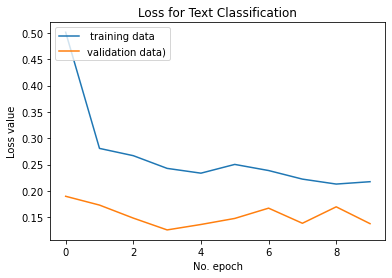

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

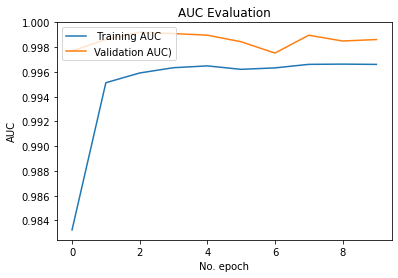

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
X_test

14268    save 53% ( morgan dollar(1896) $37.66 coins nu...
62381    2012 bowman sterling 13 vick ballard indianapo...
56367    ダブンダ〜！！！☆未開封 アメリカ 1971年 ダブルダイ入り プルーフ セット☆ 古銭 コ...
77865    goldprice fri, 19 aug 16 - 22:05 gmt | 1341.40...
22771    ksi daily report : friday, 19 august 2016 - ki...
                               ...                        
76749    spot gold price gone £1,025/toz £1,024.99/toz....
78098    goldprice fri, 19 aug 16 - 09:05 gmt | 1346.90...
17719    actus stop financial crises blockchain data st...
52310    solar knowledge power site: living earth expen...
77191    gold marked 50.00inr higher sharps pixley 31,1...
Name: tweet, Length: 8274, dtype: object

In [ ]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-22-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
259/259 [==============================] - 19s 71ms/step


array([1, 1, 1, ..., 1, 0, 2])

In [27]:
y_test.shape
y_test

14268     Neutral
62381     Neutral
56367     Neutral
77865     Neutral
22771    Positive
           ...   
76749     Neutral
78098     Neutral
17719     Neutral
52310    Negative
77191    Positive
Name: Analysis, Length: 8274, dtype: object

In [28]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

<ipython-input-28-1433c625cc9b>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_pred = np.where((y_pred == 0),'Negative',y_pred)


In [29]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       1.00      0.99      0.99      2387
    Negative       0.98      0.99      0.99       988
     Neutral       1.00      1.00      1.00      4899

    accuracy                           1.00      8274
   macro avg       0.99      0.99      0.99      8274
weighted avg       1.00      1.00      1.00      8274

